# E9: Word2Vec

In this notebook we will be exploring how well Word2Vec works on the datasets.

### Problems

1. Knowledge Base approaches have lots of problems for languages other than English. 
2. For instance, Spanish performs much worse, probably due to less structure and data in the Spanish language datasets.
3. Overall, the meanings are hand-crafted and not flexible to change.
4. We would like an approach which is easily updated and where new languages can be added with ease.

We will be using N-Grams and Word2Vec vectors trained on google news corpora.

The idea is that the N-grams will help us extrapolate some notion of inter-word meaning, textual structure and word-to-word relations.

We will be using a formula from textual entailment, which given a model answer $M$ looks for evidence supporting that answer in a student response $S$.

$$
asym(M,S) = \frac{1}{k}\sum_{i=1}^{k} max_{s_{j} \in S}(sim(m_{i}, s_{j}))
$$

where $m_{i}$ and $s_{j}$ are preprocessed n-grams of $M$ and $S$ and $k$ is the length of $M$. 

For the Word2Vec vectors, we will download the [Google News](http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/) trained vsm. **Note** : The Google News crashed my computer b/c I don't have enough RAM. So I will be using a smaller 50k word Wikipedia dataset instead.



In [4]:
import sys
import numpy as np
sys.path.append('../')
import libs.utils as utils
import libs.stats as stats
import libs.preprocessing as pp
from importlib import reload
import gensim
import libs.vsm as vsm
import spacy
reload(vsm)

<module 'libs.vsm' from '../libs/vsm.py'>

In [5]:
## Load Model
model = vsm.load_gensim_model('glove-wiki-gigaword-300')

In [16]:
# Test model
print("{}".format(model.similarity("function", "function")))
print("{}".format(model.similarity("method", "procedure")))
print("{}".format(model.n_similarity("function has a name".split(" "), "name of the function".split(" "))))
print("{}".format(model.n_similarity("function has a name".split(" "), "people have a name".split(" "))))

1.0
0.539251983165741
0.8603636026382446
0.8469036817550659


/home/che/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


## E1.1 Basic Token Comparison using Word2Vec [v2.0_en]

1. Lemmatization
2. Stopword Removal
3. Punctuation Cleanup
4. NGram Size = 1

In [17]:
df2_en = utils.load_dataframe(language='en', version=2)
nlp_en = spacy.load("en")

In [42]:
reload(pp)
reload(vsm)
def execute_model(df, sim_fn, stop_words, ngram_size):
    
    y_pred = []
    y_pred_raw = []
    y_true_raw = df['Score'].tolist()
    
    for index, row in df.iterrows():
        model_answer = row['Model Answer']
        student_answer = row['Student Answer']
        
        model_answer_tokens = vsm.preprocess(nlp_en(model_answer), stop_words)
        student_answer_tokens = vsm.preprocess(nlp_en(student_answer), stop_words)
        
        model_answer_ngrams = vsm.create_ngram_list(model_answer_tokens, ngram_size)
        student_answer_ngrams = vsm.create_ngram_list(student_answer_tokens, ngram_size)
        
        raw_score = vsm.entailment_similarity(model_answer_ngrams, student_answer_ngrams, sim_fn=sim_fn)
        pred_score = round(raw_score * 5, 0)
        y_pred_raw.append(raw_score)
        y_pred.append(pred_score)
        
        
    return {
        'y_pred' : np.array(y_pred),
        'y_pred_raw' : np.array(y_pred_raw),
        'y_true_raw' : np.array(y_true_raw),
        'y_true': np.round(y_true_raw, 0).astype(int)
    }
                                
word2word_fn = vsm.create_word_to_word_similarity_function(model)
e11_res = execute_model(df2_en, word2word_fn, pp.EN_STOPS, ngram_size=1)

/home/che/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [43]:
stats.print_big4(e11_res['y_true'], e11_res['y_pred'])
stats.print_stats(e11_res['y_true'], e11_res['y_pred'])
stats.plot_confusion_matrix(stats.cm(e11_res['y_true'], e11_res['y_pred']), classes=np.unique(e11_res['y_true']))

Accuracy: 25.430%
Precision: 55.344%
Recall: 25.430%
F1-Measure: 30.385%
Pearson's R: 0.44
Cohen's Kappa: 0.09
RMSE: 1.62
MAE: 1.25
Y-True Mean: 4.15
Y-Pred Mean: 3.10
Y-True Std Deviation: 1.12
Y-Pred Std Deviation: 1.20


## E1.2 Add Bigrams and Trigrams

In [44]:
e12_res = execute_model(df2_en, word2word_fn, pp.EN_STOPS, ngram_size=3)

/home/che/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


Accuracy: 28.460%
Precision: 57.359%
Recall: 28.460%
F1-Measure: 32.388%
Pearson's R: 0.44
Cohen's Kappa: 0.10
RMSE: 1.42
MAE: 1.06
Y-True Mean: 4.15
Y-Pred Mean: 3.35
Y-True Std Deviation: 1.12
Y-Pred Std Deviation: 1.10


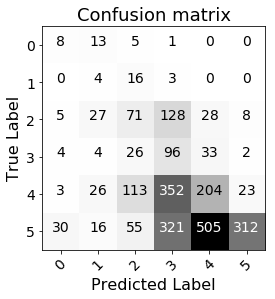

In [45]:
stats.print_big4(e12_res['y_true'], e12_res['y_pred'])
stats.print_stats(e12_res['y_true'], e12_res['y_pred'])
stats.plot_confusion_matrix(stats.cm(e12_res['y_true'], e12_res['y_pred']), classes=np.unique(e12_res['y_true']))

## E1.2a Bigrams + Trigrams for Pass / Fail

Accuracy: 81.777%
Precision: 84.308%
Recall: 81.777%
F1-Measure: 82.874%
Pearson's R: 0.30
Cohen's Kappa: 0.30
RMSE: 0.43
MAE: 0.18
Y-True Mean: 0.87
Y-Pred Mean: 0.83
Y-True Std Deviation: 0.34
Y-Pred Std Deviation: 0.38


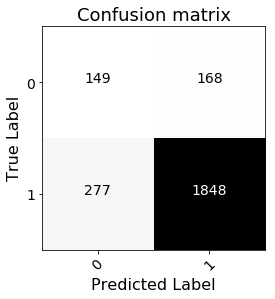

In [46]:
y_true12_pf = utils.convert_to_pass_fail(e12_res['y_true'])
y_pred12_pf = utils.convert_to_pass_fail(e12_res['y_pred'])

stats.print_big4(y_true12_pf, y_pred12_pf)
stats.print_stats(y_true12_pf, y_pred12_pf)
stats.plot_confusion_matrix(stats.cm(y_true12_pf, y_pred12_pf), classes=np.unique(y_true12_pf))